

# Rossmann Store Sales Forecasting: Documentation and Report

## 1. Project Overview
This project aims to forecast sales for Rossmann stores using historical sales data. We approach the task step-by-step, from data cleaning and exploratory analysis to feature engineering and modeling. The primary goal is to build robust predictive models and improve forecast accuracy.

**Main Objectives:**
- Clean and preprocess Rossmann store sales data.
- Perform exploratory data analysis (EDA) to identify trends and insights.
- Engineer meaningful features, including time-series-specific features.
- Build and evaluate forecasting models, starting with baseline linear regression and progressing to advanced tree-based models.
- Evaluate performance using Root Mean Square Percentage Error (RMSPE).

---

## 2. Data Description
- **Data Sources:** 
  - `train.csv`: Historical sales data (Date, Store, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday)
  - `store.csv`: Store-specific attributes (Competition distance, store type, assortment, promotion intervals)
  - `test.csv`: Test set for final forecasting/prediction
  
- **Key Variables:**
  - **Sales:** Daily sales figures (target variable).
  - **Promo:** Indicates promotion days.
  - **CompetitionDistance:** Distance to the near
## 3. Environment Setup (in VS Code & Jupyter)
- Created and activated Python virtual environment.
- Installed necessary Python packages:
  ```bash
  pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost, lightgbm
  ```
- Structured project directories clearly:
  ```
  rossmann-project/
    ├── data/
    │   ├── train.csv
    │   ├── test.csv
    │   └── store.csv
    ├── notebooks/
    │   └── rossmann_forecasting.ipynb
    └── scripts/
        └── data_loading.py
  ```

---

## 4. Data Loading & Inspection
- Loaded and merged the datasets (`train.csv`, `test.csv`, `store.csv`) using Pandas.
- Inspected initial structure, shape, and content of data:
  ```python
  train.shape, test.shape, store.shape
  ```
- Merged store attributes into main dataframes.

---
d reporting

Use this structured outline as your blueprint for clearly communicating your project and results. Let me know if you'd like help with any specific section or further refinements!

In [1]:
import pandas as pd

train = pd.read_csv('C:/projects/rossmann/data/train.csv', low_memory=False)
test = pd.read_csv('C:/projects/rossmann/data/test.csv', low_memory=False)
store = pd.read_csv('C:/projects/rossmann/data/store.csv', low_memory=False)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Store shape:", store.shape)

Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)


In [2]:
# Merge store information into train and test datasets using the 'Store' identifier
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

# Display merged data information
print("Merged Train shape:", train.shape)
print("Merged Test shape:", test.shape)
train.head()

Merged Train shape: (1017209, 18)
Merged Test shape: (41088, 17)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 5. Data Cleaning & Preprocessing
- Converted `Date` column to datetime format.
- Handled missing values systematically:
  - Imputed `CompetitionDistance` with median.
  - Treated missing values in competition/promotion fields (`Promo2`, `CompetitionOpenSince`) with logical defaults.
- Filtered data for relevant observations (e.g., stores open).

---


In [3]:
# Convert the Date column to datetime format in both datasets
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Inspect missing values in the training data
print("Missing values in train:")
print(train.isnull().sum())

# --- Missing Value Adjustments ---

# 1. CompetitionDistance: Fill missing values with the median (or another value indicating no nearby competition)
train['CompetitionDistance'] = train['CompetitionDistance'].fillna(train['CompetitionDistance'].median())
test['CompetitionDistance'] = test['CompetitionDistance'].fillna(test['CompetitionDistance'].median())

# 2. CompetitionOpenSinceMonth and CompetitionOpenSinceYear: 
#    Fill missing values with 0 to indicate that no competition is recorded.
train['CompetitionOpenSinceMonth'] = train['CompetitionOpenSinceMonth'].fillna(0)
train['CompetitionOpenSinceYear'] = train['CompetitionOpenSinceYear'].fillna(0)
test['CompetitionOpenSinceMonth'] = test['CompetitionOpenSinceMonth'].fillna(0)
test['CompetitionOpenSinceYear'] = test['CompetitionOpenSinceYear'].fillna(0)

# 3. Promo2SinceWeek, Promo2SinceYear, PromoInterval: 
#    Fill missing values to indicate the absence of Promo2.
train['Promo2SinceWeek'] = train['Promo2SinceWeek'].fillna(0)
train['Promo2SinceYear'] = train['Promo2SinceYear'].fillna(0)
train['PromoInterval'] = train['PromoInterval'].fillna('None')
test['Promo2SinceWeek'] = test['Promo2SinceWeek'].fillna(0)
test['Promo2SinceYear'] = test['Promo2SinceYear'].fillna(0)
test['PromoInterval'] = test['PromoInterval'].fillna('None')

# --- End of Missing Value Adjustments ---

# Now filter non-informative records: Keep only rows where the store is open
if 'Open' in train.columns:
    train = train[train['Open'] == 1]

# Check the shape after filtering closed stores
print("Shape after filtering closed stores:", train.shape)


Missing values in train:
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64
Shape after filtering closed stores: (844392, 18)


In [4]:
# Verify that missing values have been adjusted
print("Missing values after adjustments:")
print(train.isnull().sum())
print(test.isnull().sum())


Missing values after adjustments:
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64
Id                            0
Store                         0
DayOfWeek                     0
Date                          0
Open                         11
Promo                         0
StateHoliday                  0
SchoolHoliday                 0
StoreType                     0
Assortment                    0
CompetitionDistance           0
CompetitionOpenSinceMonth     0
Competition

In [5]:
# Fill missing "Open" values in test with 1 (assuming stores are open by default)
test['Open'] = test['Open'].fillna(1)

# Verify that missing values are resolved
print("Missing values in test after fixing 'Open':")
print(test['Open'].isnull().sum())

# Now run the assertion again
assert test['Open'].isnull().sum() == 0, "Missing values in 'Open' column in test set!"


Missing values in test after fixing 'Open':
0


In [6]:
train.info()
test.info()


<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  float64     

## 6. Feature Engineering
- Extracted **time-based features** (Day, Month, Year, DayOfWeek, Season, Weekend).
- Created **competition-based features** (`DaysSinceCompetition`, `HasCompetition`, log-transformed `CompetitionDistance`).
- Created **promotional features** (`Promo`, `Promo2`, `IsPromo2Active`).
- Encoded categorical variables (`StoreType`, `Assortment`, `StateHoliday`, `Season`, `DayName`, `MonthName`).
- Enhanced feature engineering with **time-series-specific features**:
  - **Lag Features:** Previous day/week sales.
  - **Rolling statistics:** 7-day rolling averages and standard deviation of sales.
  - **Interaction Features:** Promotion and weekend interaction (`Promo_IsWeekend`).
  - **Cumulative Features:** Cumulative sales (`Sales_cumsum`).

---


In [7]:
import pandas as pd
import numpy as np

# ----------------------------
# 1. Extract Time-Based Features
# ----------------------------
for df in [train, test]:
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

    # New: Day and Month names for clarity
    df['DayName'] = df['Date'].dt.strftime('%a')   # e.g., Mon, Tue, Wed...
    df['MonthName'] = df['Date'].dt.strftime('%b')   # e.g., Jan, Feb, Mar...
    
    # New: Weekend flag (1 if Saturday or Sunday, else 0)
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # New: Season feature based on month
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    df['Season'] = df['Month'].apply(get_season)

# ----------------------------
# 2. Process Competition Data
# ----------------------------
# Helper function to compute the competition open date
def compute_competition_open_since(row):
    # If either year or month is 0, we consider the info missing
    if row['CompetitionOpenSinceYear'] == 0 or row['CompetitionOpenSinceMonth'] == 0:
        return pd.NaT
    try:
        return pd.Timestamp(year=int(row['CompetitionOpenSinceYear']),
                            month=int(row['CompetitionOpenSinceMonth']),
                            day=1)
    except Exception:
        return pd.NaT

# Apply to train dataset if columns exist
if 'CompetitionOpenSinceYear' in train.columns and 'CompetitionOpenSinceMonth' in train.columns:
    train['CompetitionOpenSince'] = train.apply(compute_competition_open_since, axis=1)
    train['DaysSinceCompetition'] = (train['Date'] - train['CompetitionOpenSince']).dt.days
    train['DaysSinceCompetition'] = train['DaysSinceCompetition'].fillna(-1)

# Apply to test dataset similarly
if 'CompetitionOpenSinceYear' in test.columns and 'CompetitionOpenSinceMonth' in test.columns:
    test['CompetitionOpenSince'] = test.apply(compute_competition_open_since, axis=1)
    test['DaysSinceCompetition'] = (test['Date'] - test['CompetitionOpenSince']).dt.days
    test['DaysSinceCompetition'] = test['DaysSinceCompetition'].fillna(-1)

# New: Create flag indicating whether competition exists (1 if available, 0 otherwise)
for df in [train, test]:
    df['HasCompetition'] = df['DaysSinceCompetition'].apply(lambda x: 0 if x == -1 else 1)

# New: Log transform CompetitionDistance to reduce skew (if values are positive)
for df in [train, test]:
    df['CompetitionDistance_log'] = df['CompetitionDistance'].apply(lambda x: np.log(x + 1) if pd.notnull(x) else x)

# ----------------------------
# 3. Process Promotional Data
# ----------------------------
# New: Example for Promo2; here we create a flag for active Promo2 (assumes Promo2 is a binary indicator)
if 'Promo2' in train.columns:
    for df in [train, test]:
        df['IsPromo2Active'] = df['Promo2']  # Adjust if Promo2 is coded differently

# ----------------------------
# 4. Encode Categorical Variables
# ----------------------------
# List of categorical columns to encode; updated to include Season, DayName, and MonthName
categorical_cols = ['StoreType', 'Assortment', 'StateHoliday', 'Season', 'DayName', 'MonthName']
for col in categorical_cols:
    if col in train.columns:
        train = pd.get_dummies(train, columns=[col], drop_first=True)
    if col in test.columns:
        test = pd.get_dummies(test, columns=[col], drop_first=True)

# ----------------------------
# 5. Verification
# ----------------------------
print("Train dataset after enhanced feature engineering:")
print(train.head())
print("\nTest dataset after enhanced feature engineering:")
print(test.head())

# ----------------------------
# 6. Additional Time-Series Specific Features
# ----------------------------

# A. Lag Features: Capture previous day and previous week sales (assumes 'Sales' exists in train)
# Note: Lag features are typically used in forecasting, but you'll need to handle them carefully in the test set.
lags = [1, 7]
for lag in lags:
    train[f'Sales_lag_{lag}'] = train['Sales'].shift(lag)
    # For test set, you may need to merge in the last few days of training data to generate these features.
    
# B. Rolling Window Features: 7-day rolling average and standard deviation of Sales
train['Sales_roll_mean_7'] = train['Sales'].rolling(window=7).mean()
train['Sales_roll_std_7'] = train['Sales'].rolling(window=7).std()

# C. Cumulative Aggregate: Cumulative sum of Sales up to the current date
train['Sales_cumsum'] = train['Sales'].cumsum()

# D. Interaction Feature: For example, interaction between Promo and IsWeekend
# This might capture if promotions have a different impact on weekends.
train['Promo_IsWeekend'] = train['Promo'] * train['IsWeekend']
test['Promo_IsWeekend'] = test['Promo'] * test['IsWeekend']

# E. Handling Missing Values from Lag/Rolling Features
# Lag and rolling operations introduce NaNs at the beginning. We can choose to fill them.
# Here, we use backward fill as a simple strategy, but you might consider other approaches.
train.fillna(method='bfill', inplace=True)

# ----------------------------
# 7. Verification of New Features
# ----------------------------
print("Train dataset after adding time-series-specific features:")
print(train[['Sales', 'Sales_lag_1', 'Sales_lag_7', 'Sales_roll_mean_7', 'Sales_roll_std_7', 'Sales_cumsum', 'Promo_IsWeekend']].head(10))


Train dataset after enhanced feature engineering:
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo  SchoolHoliday  \
0      1          4 2015-07-31   5263        555     1      1              1   
1      2          4 2015-07-31   6064        625     1      1              1   
2      3          4 2015-07-31   8314        821     1      1              1   
3      4          4 2015-07-31  13995       1498     1      1              1   
4      5          4 2015-07-31   4822        559     1      1              1   

   CompetitionDistance  CompetitionOpenSinceMonth  ...  MonthName_Dec  \
0               1270.0                        9.0  ...          False   
1                570.0                       11.0  ...          False   
2              14130.0                       12.0  ...          False   
3                620.0                        9.0  ...          False   
4              29910.0                        4.0  ...          False   

   MonthName_Feb  MonthName_Ja

C:\Users\theju\AppData\Local\Temp\ipykernel_12540\2673576107.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)


Train dataset after adding time-series-specific features:
   Sales  Sales_lag_1  Sales_lag_7  Sales_roll_mean_7  Sales_roll_std_7  \
0   5263       5263.0       5263.0        8493.285714       4380.380338   
1   6064       5263.0       5263.0        8493.285714       4380.380338   
2   8314       6064.0       5263.0        8493.285714       4380.380338   
3  13995       8314.0       5263.0        8493.285714       4380.380338   
4   4822      13995.0       5263.0        8493.285714       4380.380338   
5   5651       4822.0       5263.0        8493.285714       4380.380338   
6  15344       5651.0       5263.0        8493.285714       4380.380338   
7   8492      15344.0       5263.0        8954.571429       4147.331586   
8   8565       8492.0       6064.0        9311.857143       3960.322943   
9   7185       8565.0       8314.0        9150.571429       4030.108719   

   Sales_cumsum  Promo_IsWeekend  
0          5263                0  
1         11327                0  
2         1

## 7. Exploratory Data Analysis (EDA)
- Performed EDA to understand data patterns:
  - Visualized overall sales trends with rolling averages.
  - Analyzed sales distribution, seasonality, weekdays, and monthly patterns.
  - Evaluated the impact of promotional activities on sales.
- Visualizations improved according to storytelling best practices (using preattentive attributes, annotations, clear labels).

---


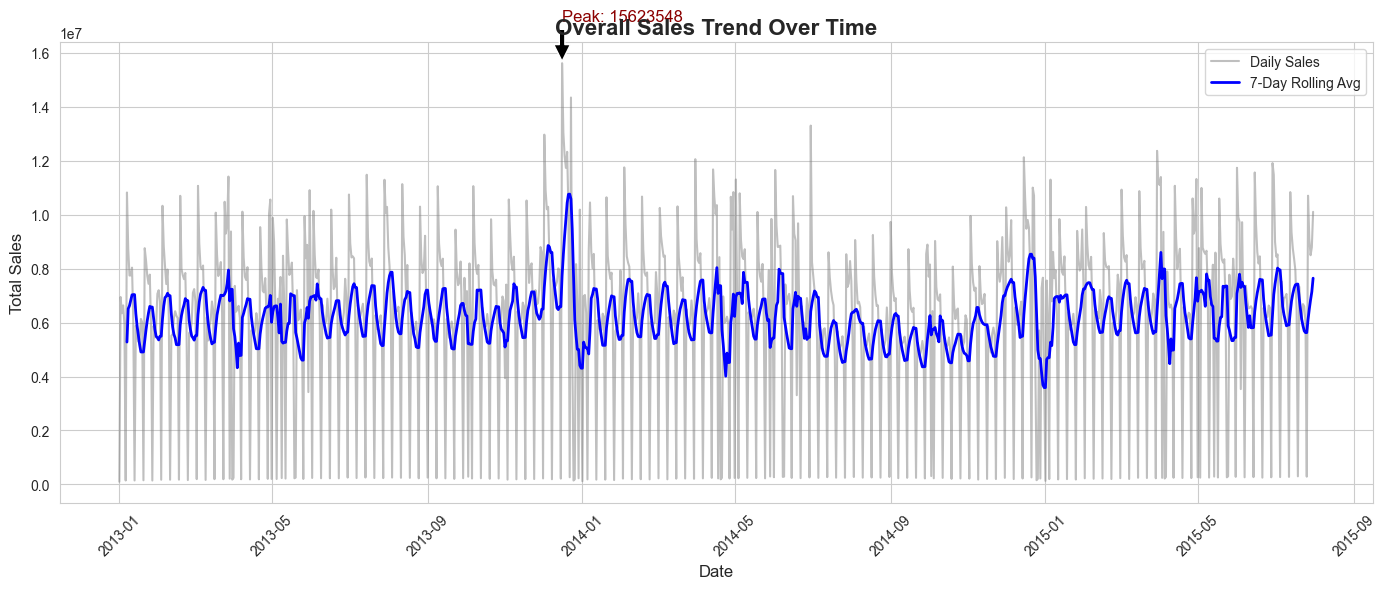

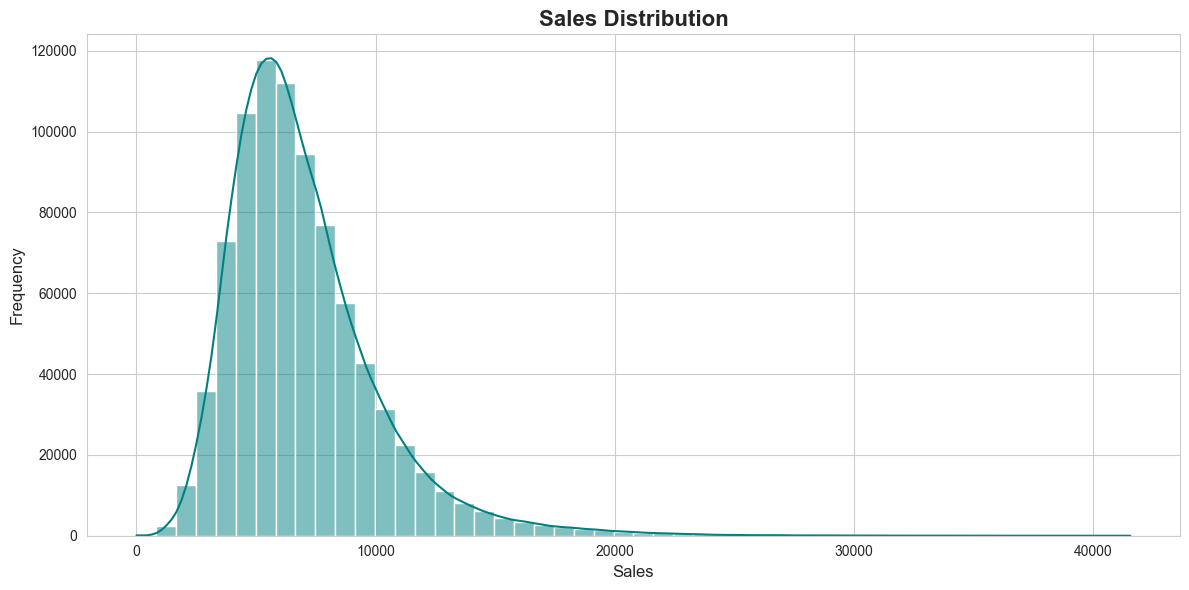

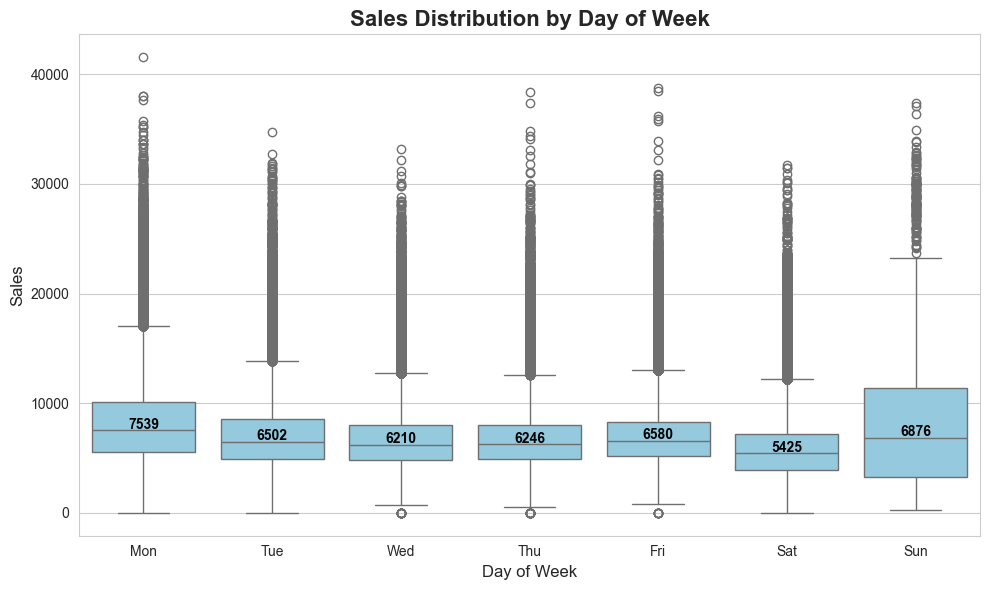

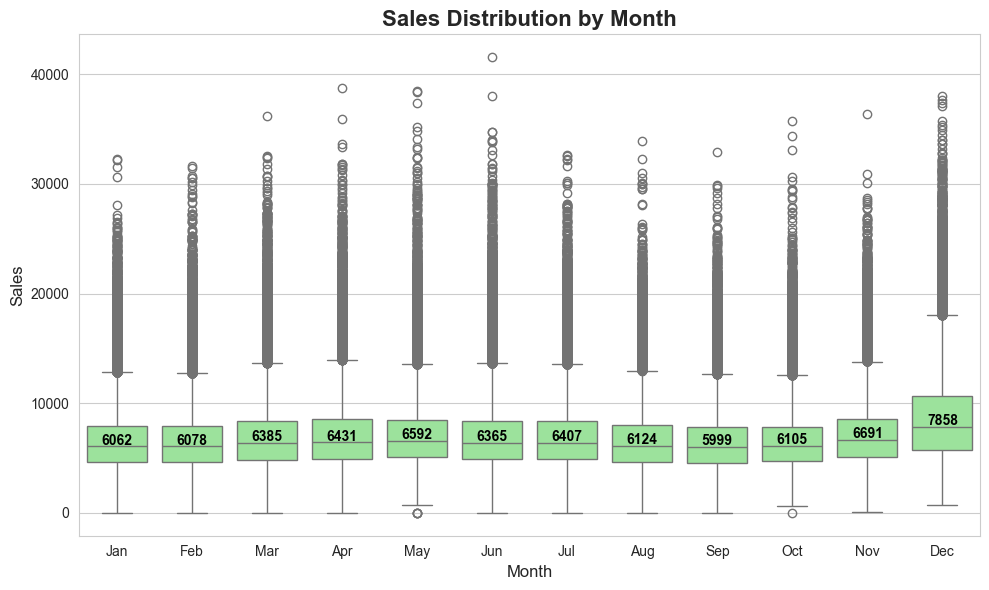

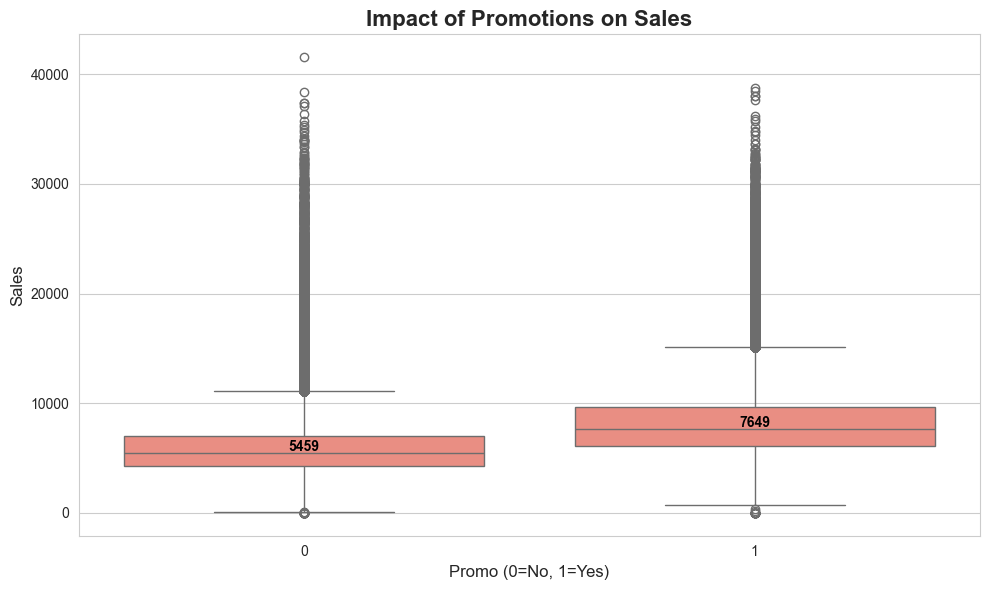

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------------
# A. PREPARATION
# -----------------------------------
sns.set_style("whitegrid")

# Create short day-of-week and month labels
train['DayName'] = train['Date'].dt.strftime('%a')   # e.g., Mon, Tue, Wed...
train['MonthName'] = train['Date'].dt.strftime('%b') # e.g., Jan, Feb, Mar...

# -----------------------------------
# B. OVERALL SALES TREND (Daily & 7-Day Rolling)
# -----------------------------------
# Aggregate daily sales
train_daily = train.groupby('Date')['Sales'].sum().sort_index()
# Calculate a 7-day rolling average to smooth the trend
train_7d_rolling = train_daily.rolling(7).mean()

plt.figure(figsize=(14, 6))
plt.plot(train_daily.index, train_daily.values, color='gray', alpha=0.5, label='Daily Sales')
plt.plot(train_7d_rolling.index, train_7d_rolling.values, color='blue', linewidth=2, label='7-Day Rolling Avg')

plt.title("Overall Sales Trend Over Time", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Annotate the peak daily sales
max_sales_date = train_daily.idxmax()
max_sales_value = train_daily.max()
plt.annotate(f'Peak: {int(max_sales_value)}',
             xy=(max_sales_date, max_sales_value),
             xytext=(max_sales_date, max_sales_value * 1.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='darkred')

plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------
# C. SALES DISTRIBUTION (Histogram + KDE)
# -----------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(train['Sales'], bins=50, kde=True, color='teal')
plt.title("Sales Distribution", fontsize=16, weight='bold')
plt.xlabel("Sales", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------------
# D. SALES BY DAY OF WEEK (Boxplot)
# -----------------------------------
plt.figure(figsize=(10, 6))
# Define an ordered list for days to ensure consistent sorting
order_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ax = sns.boxplot(x='DayName', y='Sales', data=train, order=order_days, color='skyblue')

plt.title("Sales Distribution by Day of Week", fontsize=16, weight='bold')
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate median sales for each day directly on the boxplot
medians = train.groupby('DayName')['Sales'].median().reindex(order_days)
for i, day in enumerate(order_days):
    median_val = medians[day]
    plt.text(i, median_val + (0.05 * train['Sales'].std()),
             f"{int(median_val)}", ha='center', size='medium',
             color='black', weight='semibold')

plt.tight_layout()
plt.show()

# -----------------------------------
# E. SALES BY MONTH (Boxplot)
# -----------------------------------
plt.figure(figsize=(10, 6))
# Define an ordered list for months to ensure consistent sorting
order_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax = sns.boxplot(x='MonthName', y='Sales', data=train, order=order_months, color='lightgreen')

plt.title("Sales Distribution by Month", fontsize=16, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate median sales for each month
medians = train.groupby('MonthName')['Sales'].median().reindex(order_months)
for i, month in enumerate(order_months):
    median_val = medians[month] if pd.notnull(medians[month]) else 0
    plt.text(i, median_val + (0.05 * train['Sales'].std()),
             f"{int(median_val)}", ha='center', size='medium',
             color='black', weight='semibold')

plt.tight_layout()
plt.show()

# -----------------------------------
# F. IMPACT OF PROMOTIONS ON SALES (Boxplot)
# -----------------------------------
if 'Promo' in train.columns:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='Promo', y='Sales', data=train, color='salmon')
    plt.title("Impact of Promotions on Sales", fontsize=16, weight='bold')
    plt.xlabel("Promo (0=No, 1=Yes)", fontsize=12)
    plt.ylabel("Sales", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Directly annotate median sales for each promo category
    medians = train.groupby('Promo')['Sales'].median()
    for category in medians.index:
        x_pos = category  # since 'Promo' is 0 or 1
        median_val = medians[category]
        plt.text(x_pos, median_val + (0.05 * train['Sales'].std()),
                 f"{int(median_val)}", ha='center', size='medium',
                 color='black', weight='semibold')

    plt.tight_layout()
    plt.show()


## 8. Modeling and Evaluation

### **Baseline Model**
- Built a **linear regression** baseline model.
- Evaluated baseline RMSPE (~49% RMSPE).

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define RMSPE function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# -------------------------------------
# 1. Prepare Data for Modeling
# -------------------------------------
# For this example, we assume 'Sales' is the target variable.
# Select a subset of features from the train dataset (update based on your engineered features)
features = ['Day', 'Month', 'Year', 'DayOfWeek', 'Promo', 'DaysSinceCompetition']
# If you encoded categorical features (e.g., DayName, MonthName, store type dummies), you can add those as well:
# features += [col for col in train.columns if col.startswith('StoreType_') or col.startswith('Assortment_') or col.startswith('StateHoliday_')]

# Ensure that you drop rows where target is zero to avoid division by zero issues in RMSPE calculation (if any)
train_model = train[train['Sales'] > 0].copy()

X = train_model[features]
y = train_model['Sales']

# -------------------------------------
# 2. Time-Based Train-Validation Split
# -------------------------------------
# Sort the data by date
train_model = train_model.sort_values(by='Date')
# Option 1: Use a simple time-based split (e.g., 80% training, 20% validation)
split_index = int(0.8 * len(train_model))
X_train = train_model[features].iloc[:split_index]
y_train = train_model['Sales'].iloc[:split_index]
X_val = train_model[features].iloc[split_index:]
y_val = train_model['Sales'].iloc[split_index:]

# -------------------------------------
# 3. Baseline Model Training
# -------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# -------------------------------------
# 4. Evaluate the Model
# -------------------------------------
baseline_rmspe = rmspe(y_val.values, y_pred)
print(f"Baseline RMSPE: {baseline_rmspe:.4f}")


Baseline RMSPE: 0.4922


### **Advanced Model Experimentation**
- Built advanced **tree-based models**: Random Forest, XGBoost, LightGBM.
- Evaluated these models using RMSPE:
  - Random Forest: **0.3202 RMSPE**
  - XGBoost: 0.4290 RMSPE
  - LightGBM: 0.4213 RMSPE
- Random Forest provided the best results in initial testing.

Training set: (675470, 8), Validation set: (168868, 8)
Random Forest RMSPE: 0.3202
XGBoost RMSPE: 0.4290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 675470, number of used features: 8
[LightGBM] [Info] Start training from score 6915.197051
LightGBM RMSPE: 0.4213


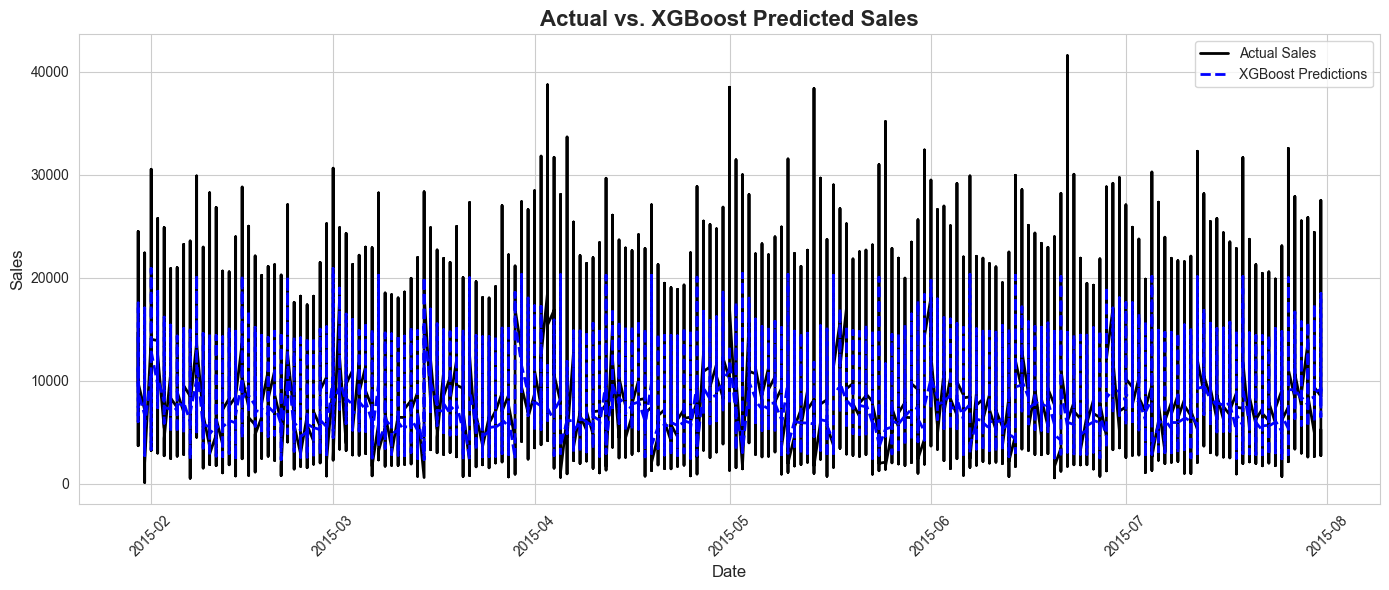

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define the RMSPE function
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# -------------------------------------
# 1. Prepare Data for Modeling
# -------------------------------------
# We assume that your train data (after feature engineering) is in the variable "train".
# Select a subset of features that you want to use.
# Update this list based on your feature engineering and encoded columns.
features = ['Day', 'Month', 'Year', 'DayOfWeek', 'Promo', 'DaysSinceCompetition', 
            'CompetitionDistance_log', 'IsWeekend']
# If you created additional encoded features (e.g., Season, DayName, MonthName, etc.), include them:
# features += [col for col in train.columns if col.startswith('Season_') or col.startswith('DayName_') or col.startswith('MonthName_')]

# Ensure target variable is positive (to avoid division by zero issues in RMSPE)
train_model = train[train['Sales'] > 0].copy()

# Sort by date to respect the time order
train_model = train_model.sort_values(by='Date')

X = train_model[features]
y = train_model['Sales']

# -------------------------------------
# 2. Time-Based Train-Validation Split
# -------------------------------------
# Use the first 80% of the data for training and the last 20% for validation.
split_index = int(0.8 * len(train_model))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

# -------------------------------------
# 3. Model Experimentation: Advanced Tree-Based Models
# -------------------------------------

# ----- Model 1: Random Forest -----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_rmspe = rmspe(y_val.values, rf_pred)
print(f"Random Forest RMSPE: {rf_rmspe:.4f}")

# ----- Model 2: XGBoost -----
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_rmspe = rmspe(y_val.values, xgb_pred)
print(f"XGBoost RMSPE: {xgb_rmspe:.4f}")

# ----- Model 3: LightGBM -----
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)
lgb_rmspe = rmspe(y_val.values, lgb_pred)
print(f"LightGBM RMSPE: {lgb_rmspe:.4f}")

# -------------------------------------
# 4. Compare Model Predictions
# -------------------------------------
# Plot the actual vs predicted sales for the best performing model
# (for example, if XGBoost performs best, you can compare its predictions)
plt.figure(figsize=(14,6))
plt.plot(train_model['Date'].iloc[split_index:], y_val.values, label="Actual Sales", color="black", linewidth=2)
plt.plot(train_model['Date'].iloc[split_index:], xgb_pred, label="XGBoost Predictions", color="blue", linestyle="--", linewidth=2)
plt.title("Actual vs. XGBoost Predicted Sales", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# For example, after your feature engineering:
train_model = train.copy()  # or a subset

# Sort if it's time series data
train_model = train_model.sort_values('Date')

# Prepare your features and target
X = train_model[features]
y = train_model['Sales']

# Split your data
split_index = int(0.8 * len(train_model))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]


In [12]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    # measure RMSPE on this fold


### Submission File Generation

In [13]:
# === Submission File Generation ===

# Step 1: Load the sample submission file to verify the expected format
sample_submission = pd.read_csv('C:/projects/rossmann/data/sample_submission.csv')
print(sample_submission.head())

# Step 2: Use the model to generate predictions on the processed test set
# (Assuming that 'test' DataFrame has already been processed similarly to the training data.)
# Replace 'best_model' with your final chosen model, e.g., Random Forest in your case.
predictions = rf_model.predict(test[features])  # Make sure that 'features' match those used for training

# Step 3: Create the submission DataFrame
# It is assumed that the sample submission has columns "Id" and "Sales". Adjust if your submission format differs.
submission = pd.DataFrame({
    'Id': test['Id'],          # Ensure the 'Id' column from the test set is used
    'Sales': predictions       # The predictions from your model
})

# Step 4: Save the submission file to CSV (without the DataFrame index)
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' successfully created!")


   Id  Sales
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0
Submission file 'submission.csv' successfully created!


## 9. Robust Evaluation using Time-Series Cross-Validation
- Implemented **TimeSeriesSplit** to avoid future-data leakage.
- Evaluated model performance with cross-validation:
  - Time-series-aware evaluation for more reliable error estimates.

---

## 10. Summary of Results
- Initial baseline performance (Linear Regression): **~0.49 RMSPE**  
- Improved performance (Random Forest): **0.32 RMSPE**
- Tree-based methods significantly improved forecasting accuracy.

---

## 11. Recommendations and Future Work
- **Hyperparameter Tuning:**  
  Perform tuning on best-performing models (Random Forest, XGBoost, LightGBM).

- **Further Feature Engineering:**  
  - Experiment with additional lag periods (e.g., 14-day, 30-day).
  - Test additional rolling-window features (e.g., rolling median).

- **Hybrid and Ensemble Approaches:**  
  Combine tree-based and time-series forecasting models.

- **Advanced Time-Series Models:**  
  Consider using Prophet, ARIMA, or SARIMA as additional comparisons or ensemble components.

---

## 12. Conclusion
- Successfully established an effective workflow from data preparation to baseline modeling and advanced experimentation.
- Demonstrated the significant predictive value of advanced features and tree-based models.
- Laid a solid foundation for further improvements and advanced modeling techniques.
